Load necessary libs and set up caffe and caffe_root

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
import os
os.chdir('..')
caffe_root = './'
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
caffe.set_device(3)
caffe.set_mode_gpu()

coco_net = caffe.Net(caffe_root + 'models/VGGNet/coco/refinedet_vgg16_320x320/deploy.prototxt',
                     caffe_root + 'models/VGGNet/coco/refinedet_vgg16_320x320/coco_refinedet_vgg16_320x320_final.caffemodel',
                     caffe.TEST)

voc_net = caffe.Net(caffe_root + 'models/VGGNet/VOC0712/refinedet_vgg16_320x320/deploy.prototxt',
                    caffe_root + 'models/VGGNet/VOC0712/refinedet_vgg16_320x320/VOC0712_refinedet_vgg16_320x320_final.caffemodel',
                    caffe.TEST)

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load MS COCO model specs
file = open(caffe_root + 'models/VGGNet/coco/refinedet_vgg16_320x320/deploy.prototxt', 'r')
coco_netspec = caffe_pb2.NetParameter()
text_format.Merge(str(file.read()), coco_netspec)

# load MS COCO labels
coco_labelmap_file = caffe_root + 'data/coco/labelmap_coco.prototxt'
file = open(coco_labelmap_file, 'r')
coco_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), coco_labelmap)

# load PASCAL VOC model specs
file = open(caffe_root + 'models/VGGNet/VOC0712/refinedet_vgg16_320x320/deploy.prototxt', 'r')
voc_netspec = caffe_pb2.NetParameter()
text_format.Merge(str(file.read()), voc_netspec)

# load PASCAL VOC labels
voc_labelmap_file = caffe_root + 'data/VOC0712/labelmap_voc.prototxt'
file = open(voc_labelmap_file, 'r')
voc_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), voc_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

In [3]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': coco_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Load an image. 

In [4]:
image = caffe.io.load_image(caffe_root + 'examples/images/fish-bike.jpg')
transformed_image = transformer.preprocess('data', image)

# set net to batch size of 1
coco_net.blobs['data'].reshape(1,3,320,320)
voc_net.blobs['data'].reshape(1,3,320,320)

# resizes the image to the right size, applies transformation etc. 
coco_net.blobs['data'].data[...] = transformed_image
voc_net.blobs['data'].data[...] = transformed_image

orig_image = transformer.deprocess('data', coco_net.blobs['data'].data)

Top5 detections using coco model.

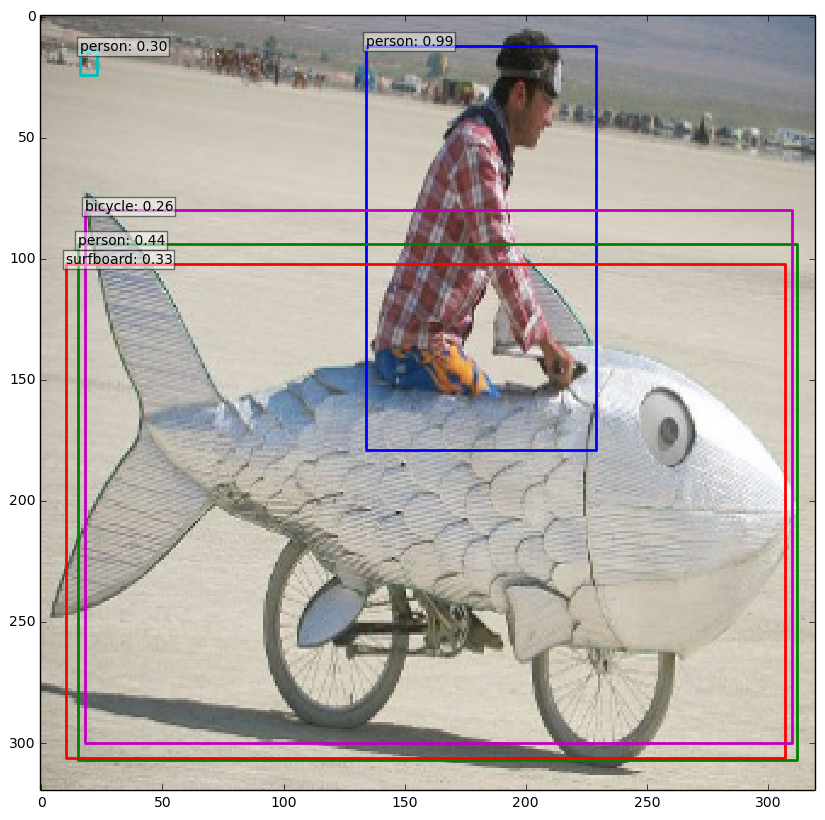

In [5]:
detections = coco_net.forward()['detection_out']

# parse the output
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
#print det_conf
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# get topN detections
top_k = 5
topk_indexes = det_conf.argsort()[::-1][:top_k]

top_conf = det_conf[topk_indexes]
top_label_indexes = det_label[topk_indexes]
top_labels = get_labelname(coco_labelmap, top_label_indexes.tolist())

top_xmin = det_xmin[topk_indexes]
top_ymin = det_ymin[topk_indexes]
top_xmax = det_xmax[topk_indexes]
top_ymax = det_ymax[topk_indexes]

plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.imshow(orig_image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * 320.0))
    ymin = int(round(top_ymin[i] * 320.0))
    xmax = int(round(top_xmax[i] * 320.0))
    ymax = int(round(top_ymax[i] * 320.0))
    score = top_conf[i]
    label = top_labels[i]
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=plot_colors[i % len(plot_colors)] , linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})

Top5 detections using voc model.

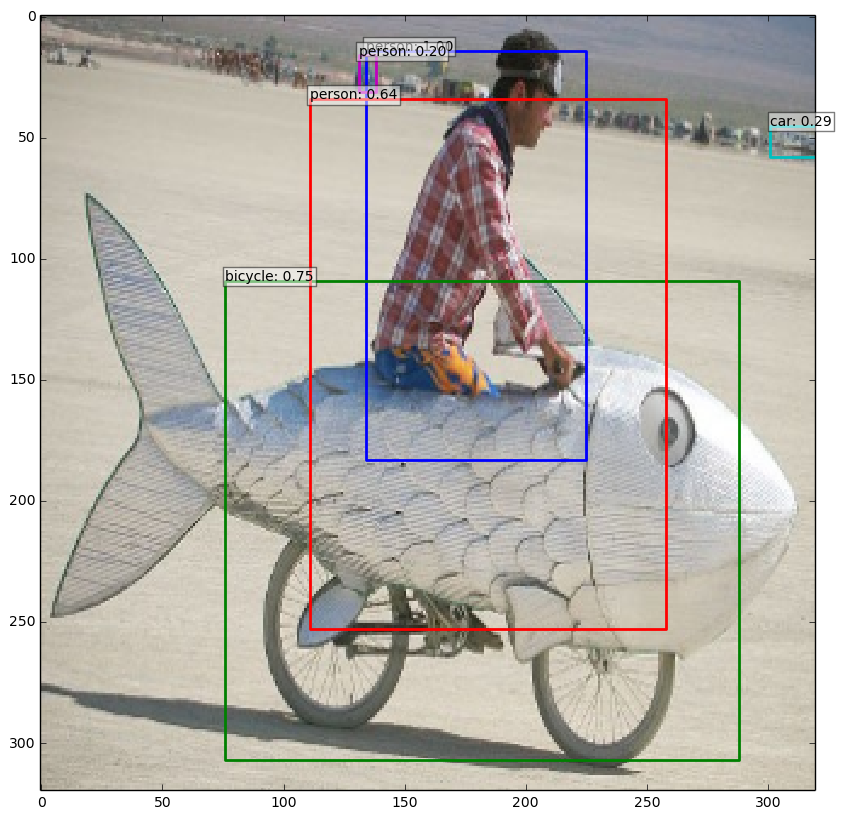

In [6]:
detections = voc_net.forward()['detection_out']

# parse the output
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
#print det_conf
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# get topN detections
top_k = 5
topk_indexes = det_conf.argsort()[::-1][:top_k]

top_conf = det_conf[topk_indexes]
top_label_indexes = det_label[topk_indexes]
top_labels = get_labelname(voc_labelmap, top_label_indexes.tolist())

top_xmin = det_xmin[topk_indexes]
top_ymin = det_ymin[topk_indexes]
top_xmax = det_xmax[topk_indexes]
top_ymax = det_ymax[topk_indexes]

plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.imshow(orig_image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * 320.0))
    ymin = int(round(top_ymin[i] * 320.0))
    xmax = int(round(top_xmax[i] * 320.0))
    ymax = int(round(top_ymax[i] * 320.0))
    score = top_conf[i]
    label = top_labels[i]
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=plot_colors[i % len(plot_colors)] , linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})

In [7]:
for layer_name, param in coco_net.params.iteritems():
    if len(param) == 2:
        print(layer_name + '\t' + str(param[0].data.shape) + str(param[1].data.shape))
    else:
        print(layer_name + '\t' + str(param[0].data.shape))

conv1_1	(64, 3, 3, 3)(64,)
conv1_2	(64, 64, 3, 3)(64,)
conv2_1	(128, 64, 3, 3)(128,)
conv2_2	(128, 128, 3, 3)(128,)
conv3_1	(256, 128, 3, 3)(256,)
conv3_2	(256, 256, 3, 3)(256,)
conv3_3	(256, 256, 3, 3)(256,)
conv4_1	(512, 256, 3, 3)(512,)
conv4_2	(512, 512, 3, 3)(512,)
conv4_3	(512, 512, 3, 3)(512,)
conv5_1	(512, 512, 3, 3)(512,)
conv5_2	(512, 512, 3, 3)(512,)
conv5_3	(512, 512, 3, 3)(512,)
fc6	(1024, 512, 3, 3)(1024,)
fc7	(1024, 1024, 1, 1)(1024,)
conv6_1	(256, 1024, 1, 1)(256,)
conv6_2	(512, 256, 3, 3)(512,)
TL6_1	(256, 512, 3, 3)(256,)
TL6_2	(256, 256, 3, 3)(256,)
P6	(256, 256, 3, 3)(256,)
TL5_1	(256, 1024, 3, 3)(256,)
TL5_2	(256, 256, 3, 3)(256,)
P6-up	(256, 256, 2, 2)(256,)
P5	(256, 256, 3, 3)(256,)
conv5_3_norm	(512,)
TL4_1	(256, 512, 3, 3)(256,)
TL4_2	(256, 256, 3, 3)(256,)
P5-up	(256, 256, 2, 2)(256,)
P4	(256, 256, 3, 3)(256,)
conv4_3_norm	(512,)
TL3_1	(256, 512, 3, 3)(256,)
TL3_2	(256, 256, 3, 3)(256,)
P4-up	(256, 256, 2, 2)(256,)
P3	(256, 256, 3, 3)(256,)
conv4_3_norm_mbox_l

Subsampling parameters from coco

In [8]:
map_file = caffe_root + 'data/VOC0712/coco_voc_map.txt'
if not os.path.exists(map_file):
    print('{} does not exist'.format(map_file))
    
maps = np.loadtxt(map_file, str, delimiter=',')
for m in maps:
    [coco_label, voc_label, name] = m
    coco_name = get_labelname(coco_labelmap, int(coco_label))[0]
    voc_name = get_labelname(voc_labelmap, int(voc_label))[0]
    assert voc_name == name
    print('{}, {}'.format(coco_name, voc_name))

def sample_param(src_param, src_num_classes, dst_num_classes, num_bboxes, maps):
    src_shape = src_param.shape
    assert src_shape[0] == src_num_classes * num_bboxes
    if len(src_shape) == 4:
        dst_shape = (dst_num_classes * num_bboxes, src_shape[1], src_shape[2], src_shape[3])
    else:
        dst_shape = dst_num_classes * num_bboxes
    dst_param = np.zeros(dst_shape)
    for i in xrange(0, num_bboxes):
        for m in maps:
            [src_label, dst_label, name] = m
            src_idx = i * src_num_classes + int(src_label)
            dst_idx = i * dst_num_classes + int(dst_label)
            dst_param[dst_idx,] = src_param[src_idx,]
    return dst_param


mbox_source_layers = ['P3', 'P4', 'P5', 'P6']
num_bboxes = [3, 3, 3, 3]
assert len(mbox_source_layers) == len(num_bboxes)
num_voc_classes = 21
num_coco_classes = 81

for i in xrange(0, len(mbox_source_layers)):
    mbox_source_layer = mbox_source_layers[i]
    mbox_priorbox_layer = '{}_mbox_priorbox'.format(mbox_source_layer)
    mbox_loc_layer = '{}_mbox_loc'.format(mbox_source_layer)
    mbox_conf_layer = '{}_mbox_conf'.format(mbox_source_layer)
    num_bbox = num_bboxes[i]
    for j in xrange(0, len(coco_netspec.layer)):
        layer = coco_netspec.layer[j]
        if mbox_priorbox_layer == layer.name:
            voc_netspec.layer[j].prior_box_param.CopyFrom(layer.prior_box_param)
        if mbox_loc_layer == layer.name:
            voc_netspec.layer[j].convolution_param.num_output = num_bbox * 4
        if mbox_conf_layer == layer.name:
            voc_netspec.layer[j].convolution_param.num_output = num_bbox * num_voc_classes

new_voc_model_dir = caffe_root + 'models/VGGNet/VOC0712/refinedet_vgg16_320x320_coco'
if not os.path.exists(new_voc_model_dir):
    os.makedirs(new_voc_model_dir)
# del voc_netspec.layer[-1]
new_voc_model_def_file = '{}/deploy.prototxt'.format(new_voc_model_dir)
with open(new_voc_model_def_file, 'w') as f:
    print(voc_netspec, file=f)
    
voc_net_new = caffe.Net(new_voc_model_def_file, caffe.TEST)
new_voc_model_file = '{}/coco_refinedet_vgg16_320x320.caffemodel'.format(new_voc_model_dir)

for layer_name, param in coco_net.params.iteritems():
    if 'mbox' in layer_name and 'P' in layer_name:
        continue
    else:
        for i in xrange(0, len(param)):
            voc_net_new.params[layer_name][i].data.flat = coco_net.params[layer_name][i].data.flat

for i in xrange(0, len(mbox_source_layers)):
    layer = mbox_source_layers[i]
    num_bbox = num_bboxes[i]
    conf_layer = '{}_mbox_conf'.format(layer)
    voc_net_new.params[conf_layer][0].data.flat = sample_param(coco_net.params[conf_layer][0].data,
                                                      len(coco_labelmap.item), len(voc_labelmap.item), num_bbox, maps)
    voc_net_new.params[conf_layer][1].data.flat = sample_param(coco_net.params[conf_layer][1].data,
                                                      len(coco_labelmap.item), len(voc_labelmap.item), num_bbox, maps)
    loc_layer = '{}_mbox_loc'.format(layer)
    voc_net_new.params[loc_layer][0].data.flat = coco_net.params[loc_layer][0].data.flat
    voc_net_new.params[loc_layer][1].data.flat = coco_net.params[loc_layer][1].data.flat
voc_net_new.save(new_voc_model_file)

background, background
airplane, aeroplane
bicycle, bicycle
bird, bird
boat, boat
bottle, bottle
bus, bus
car, car
cat, cat
chair, chair
cow, cow
dining table, diningtable
dog, dog
horse, horse
motorcycle, motorbike
person, person
potted plant, pottedplant
sheep, sheep
couch, sofa
train, train
tv, tvmonitor


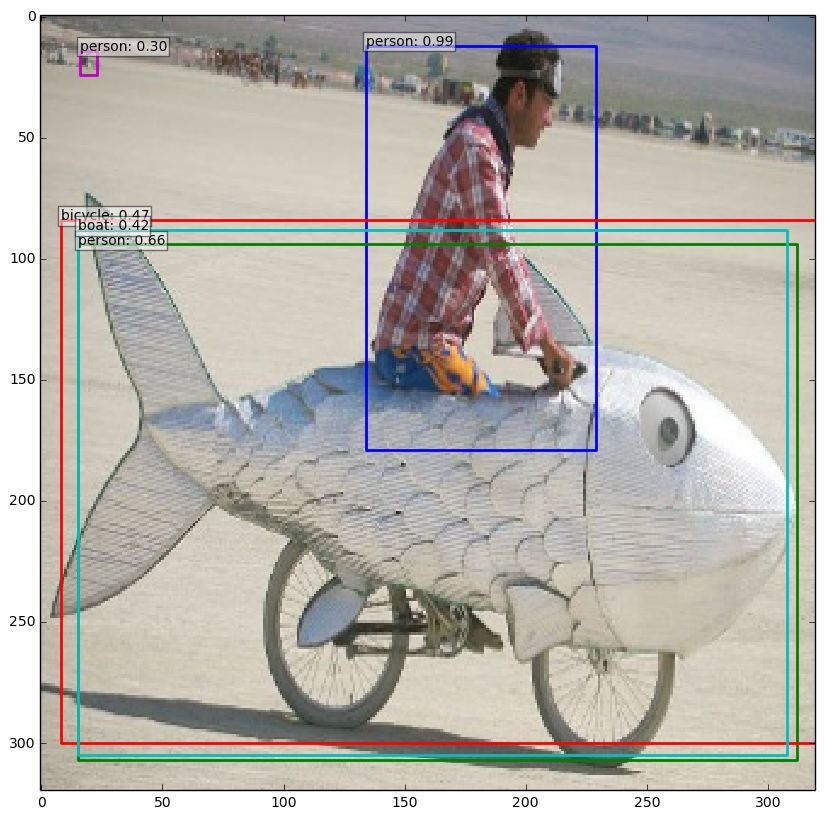

In [9]:
voc_net = caffe.Net(caffe_root + 'models/VGGNet/VOC0712/refinedet_vgg16_320x320_coco/deploy.prototxt',
                    caffe_root + 'models/VGGNet/VOC0712/refinedet_vgg16_320x320_coco/coco_refinedet_vgg16_320x320.caffemodel',
                    caffe.TEST)
voc_net.blobs['data'].reshape(1,3,320,320)

# resizes the image to the right size, applies transformation etc. 
voc_net.blobs['data'].data[...] = transformed_image

detections = voc_net.forward()['detection_out']

# parse the output
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
#print det_conf
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# get topN detections
top_k = 5
topk_indexes = det_conf.argsort()[::-1][:top_k]

top_conf = det_conf[topk_indexes]
top_label_indexes = det_label[topk_indexes]
top_labels = get_labelname(voc_labelmap, top_label_indexes.tolist())

top_xmin = det_xmin[topk_indexes]
top_ymin = det_ymin[topk_indexes]
top_xmax = det_xmax[topk_indexes]
top_ymax = det_ymax[topk_indexes]

plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.imshow(orig_image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * 320.0))
    ymin = int(round(top_ymin[i] * 320.0))
    xmax = int(round(top_xmax[i] * 320.0))
    ymax = int(round(top_ymax[i] * 320.0))
    score = top_conf[i]
    label = top_labels[i]
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=plot_colors[i % len(plot_colors)] , linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})